In [1]:
# This file is a simulation of a simple single phase (single phase, not 3 phase balanced) network with inverter
'''
This file is a simulation of a simple single phase (single phase, not 3 phase balanced) network,
with inverters providing reactive power compensation. The inverters can be attacked, with the attacker
altering the Volt-VAr curve to create oscillations.
'''

'\nThis file is a simulation of a simple single phase (single phase, not 3 phase balanced) network,\nwith inverters providing reactive power compensation. The inverters can be attacked, with the attacker\naltering the Volt-VAr curve to create oscillations.\n'

In [2]:
# Import necessary packages

import numpy as np
import opendssdirect as dss
from utils.device.Inverter import Inverter
from utils.controller.AdaptiveInvController import AdaptiveInvController
from utils.controller.FixedInvController import FixedInvController
import matplotlib.pyplot as plt
from math import tan,acos
import copy
import pandas as pd
import time

%matplotlib inline

# import numpy as np
# from matplotlib.mlab import PCA
from sklearn.decomposition import PCA

import scipy.linalg as spla

In [3]:
# Set global variables and parameters, and test OpenDSS with network


#######################################################
###Global variable initialization and error checking###
#######################################################

Sbase=1
LoadScalingFactor = 3
GenerationScalingFactor = 5
SlackBusVoltage = 1.00
NoiseMultiplyer= 1
#Set simulation analysis period - the simulation is from StartTime to EndTime
StartTime = 40600
EndTime = StartTime + 640
EndTime += 1 # creating a list, last element does not count, so we increase EndTime by 1
#Set hack parameters
TimeStepOfHack = 160
PercentHacked = np.array([0,0,0,0,0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0,0,0,0,0,0,0,0,0,0,0,0,0])

#Set initial VBP parameters for uncompromised inverters
VBP_normal=np.array([0.97, 1, 1, 1.03, 1.06])
VBP_attack=np.array([0.997, 1, 1, 1.003, 1.007])

#Set delays for each node
Delay_VBPCurveShift = (30+2*np.random.randn(31)).astype(int)
#Delay_VBPCurveShift = (10+2*np.random.randn(31)).astype(int)
lpf_meas_vector = (1+0.2*np.random.randn(31))
lpf_output_vector= (0.1+0.015*np.random.randn(31))

#Set observer voltage threshold
ThreshHold_vqvp = 0.06
adaptive_gain=800


power_factor=0.9
pf_converted=tan(acos(power_factor))
# Number_of_Inverters = 13 #even feeder is 34Bus, we only have 13 inverters


#Error checking of the global variable -- TODO: add error handling here!
if EndTime < StartTime or EndTime < 0 or StartTime < 0:
    print('Setup Simulation Times Inappropriately.')
if NoiseMultiplyer < 0:
    print('Setup Noise Multiplyer Correctly.')

# Select OpenDSS file
dss.run_command('Redirect feeder/03node_singlephase_balanced.dss')

# Solve power flow with OpenDSS file
dss.Solution.Solve()
if not dss.Solution.Converged:
    print('Initial Solution Not Converged. Check Model for Convergence')
else:
    print('Initial Model Converged. Proceeding to Next Step.')
    #Doing this solve command is required for GridPV, that is why the monitors
    #go under a reset process
    dss.Monitors.ResetAll()
    
    #set solution Params
    #setSolutionParams(dss,'daily',1,1,'off',1000000,30000)
    dss.Solution.Mode(1)
    dss.Solution.Number(1)
    dss.Solution.StepSize(1)
    dss.Solution.ControlMode(-1)
    dss.Solution.MaxControlIterations(1000000)
    dss.Solution.MaxIterations(30000)
    #Easy process to get all names and count of loads, a trick to avoid
    #some more lines of code
    TotalLoads=dss.Loads.Count()
    AllLoadNames=dss.Loads.AllNames()
    print('OpenDSS Model Compliation Done.')

print('')

# Print number of buses, and bus names
print(len(dss.Circuit.AllBusNames()))
print(dss.Circuit.AllBusNames())

# Print number of loads, and load names
print(len(dss.Loads.AllNames()))
print(dss.Loads.AllNames())

print('')

# Print different voltage measurements
for k1 in range(len(dss.Circuit.AllBusNames())):
    if dss.Circuit.AllBusNames()[k1] == 'sourcebus':
        dss.Circuit.SetActiveBus(dss.Circuit.AllBusNames()[k1])
        
        print(dss.Circuit.AllBusNames()[k1])
        print('BASE - LN')
        print(dss.Bus.kVBase())
        print('VMAGANGLE - LN POLAR')
        print(dss.Bus.VMagAngle())
        print('puVMAGANGLE - LN POLAR')
        print(dss.Bus.puVmagAngle())
        print('VOTLAGES - LN CARTESIAN')
        print(dss.Bus.Voltages())
        print('puVOTLAGES - LN CARTESIAN')
        print(dss.Bus.PuVoltage())
        print('VLL - LL CARTESIAN')
        print(dss.Bus.VLL())
        print('puVLL - LL CARTESIAN')
        print(dss.Bus.puVLL())
        
        tempvoltage = dss.Bus.Voltages()
        
        Vab = tempvoltage[0]
        
print('')
        
for k1 in range(len(dss.Circuit.AllBusNames())):
    dss.Circuit.SetActiveBus(dss.Circuit.AllBusNames()[k1])
    print(dss.Circuit.AllBusNames()[k1])
    print('BASE - LN')
    print(dss.Bus.kVBase())
    print('VMAGANGLE - LN POLAR')
    print(dss.Bus.VMagAngle())
    print('puVMAGANGLE - LN POLAR')
    print(dss.Bus.puVmagAngle())
    print('')

    
# dir(dss.Bus)

Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.

6
['sourcebus', '799', '799r', '701', '702', '703']
3
['s701a', 's702a', 's703a']

sourcebus
BASE - LN
132.79056191361394
VMAGANGLE - LN POLAR
[132789.68368276686, -0.0005120334097101769, 132790.48493181812, -120.00001171603705, 132790.6239589436, 119.99997710207259]
puVMAGANGLE - LN POLAR
[0.9999933863458788, -0.0005120334097101769, 0.9999994202766017, -120.00001171603705, 1.0000004672420144, 119.99997710207259]
VOTLAGES - LN CARTESIAN
[132789.68367746432, -1.1866974337551506, -66395.26599442096, -114999.91974761331, -66395.26603329257, 115000.08025985837]
puVOTLAGES - LN CARTESIAN
[0.999993386305947, -8.936609775980533e-06, -0.49999988732342276, -0.8660247994313466, -0.4999998876161515, 0.8660260081937974]
VLL - LL CARTESIAN
[199184.9496718853, 114998.73305017955, 3.8871614378876984e-05, -230000.00000747168, -199184.9497107569, 115001.26695729213]
puVLL - LL CARTESIAN
[0.8660215203125448, 0.49999449152

In [4]:
A = np.random.randn(2,2)
A = np.array([[0, 1],[-2, -1]])

x = np.random.randn(2,8)
y = A@x

print(A)
print(x)
print(y)

# print(y.T)
# print(y.T.reshape((-1, 1), order="F"))

yls = y.T.reshape((-1, 1), order="F")
xls = spla.block_diag(x.T,x.T)

print(xls)

Bvec = spla.inv(xls.T@xls)@(xls.T@yls)

print(Bvec)

B = Bvec.reshape((2,2), order='F')
print(B)
A = B.T
print(A)

[[ 0  1]
 [-2 -1]]
[[-0.20823954  1.04018543 -0.13951875 -0.22601585 -0.27905077 -0.2848569
   0.97435106 -1.37363185]
 [ 0.9236076   0.72908115 -2.121959    0.28263047 -0.24256066 -0.92522936
  -0.25247825  0.26915994]]
[[ 0.9236076   0.72908115 -2.121959    0.28263047 -0.24256066 -0.92522936
  -0.25247825  0.26915994]
 [-0.50712853 -2.809452    2.40099651  0.16940123  0.8006622   1.49494317
  -1.69622386  2.47810376]]
[[-0.20823954  0.9236076   0.          0.        ]
 [ 1.04018543  0.72908115  0.          0.        ]
 [-0.13951875 -2.121959    0.          0.        ]
 [-0.22601585  0.28263047  0.          0.        ]
 [-0.27905077 -0.24256066  0.          0.        ]
 [-0.2848569  -0.92522936  0.          0.        ]
 [ 0.97435106 -0.25247825  0.          0.        ]
 [-1.37363185  0.26915994  0.          0.        ]
 [ 0.          0.         -0.20823954  0.9236076 ]
 [ 0.          0.          1.04018543  0.72908115]
 [ 0.          0.         -0.13951875 -2.121959  ]
 [ 0.          

[[ 0.95    0.099 ]
 [-0.99    0.9302]]
[0.9401+0.31290892j 0.9401-0.31290892j]
[0.99080775 0.99080775]


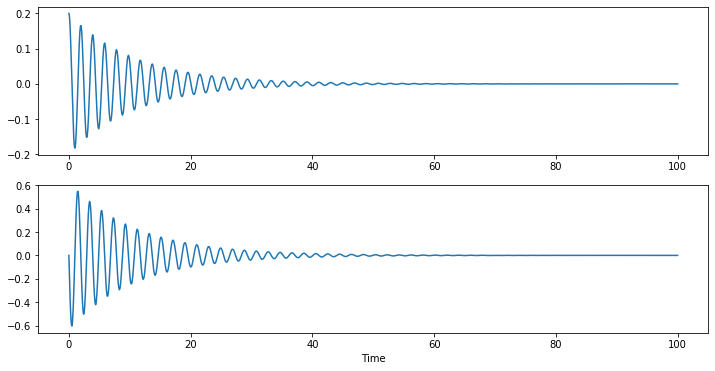

(4, 4)
(4, 1)
[[ 0.95    0.099 ]
 [-0.99    0.9302]]
(4, 4)
(4, 1)
[[ 0.95    0.099 ]
 [-0.99    0.9302]]
(4, 4)
(4, 1)
[[ 0.95    0.099 ]
 [-0.99    0.9302]]
(4, 4)
(4, 1)
[[ 0.95    0.099 ]
 [-0.99    0.9302]]
(4, 4)
(4, 1)
[[ 0.95    0.099 ]
 [-0.99    0.9302]]


In [5]:

Ts = 0.1

m = 1
b = 0.2
k = 10

Ac = np.array([[0, 1],[-k/m, -b/m]])

Ad = spla.expm(Ac*Ts)
Ad = np.eye(2) + Ts*Ac + 1/2*Ts**2*Ac@Ac


print(Ad)

evals, evecs = spla.eig(Ad)
print(evals)
print(np.abs(evals))

time = Ts*np.arange(0,1001)

x = np.zeros((2,len(time)))
x[:,0] = [0.2, 0]

# print(len(time))
# print(x.shape)

for kt in range(len(time)-1):
    
    x[:,[kt+1]] = Ad@x[:,[kt]]
    
fig = plt.figure(figsize=[12,6])
plt.subplot(2,1,1)
plt.plot(time,x[0,:])
# plt.title('Node Active Power Injection')
# # plt.xlabel('Time')
# plt.ylabel('Active Power Injection [kW]')
plt.subplot(2,1,2)
plt.plot(time,x[1,:])
# plt.plot(time/3600,QinjTS[plotStartTimeStep:plotEndTimeStep,:])
# plt.title('Node Reactive Power Injection')
plt.xlabel('Time')
# plt.ylabel('Reactive Power Injection [kVAr]')
plt.show()


Ns = 2

for kt in range(0,5):
    
    xx = x[:,kt:kt+Ns]
#     print(xx)
    
    yy = x[:,kt+1:kt+1+Ns]
#     print(yy)

    xxblkdiag = spla.block_diag(xx.T,xx.T)
#     for k1 in range(0,1):
#         xxblkdiag = spla.block_diag(xxblkdiag,xx.T)
    print(xxblkdiag.shape)

    yyvec = yy.T.reshape((-1,1), order='F')
    print(yyvec.shape)

    Bvec = spla.inv(xxblkdiag.T@xxblkdiag)@(xxblkdiag.T@yyvec)
    
    A = Bvec.reshape((2,2), order='F').T
    print(A)
    
    
    
    
#     A = np.random.randn(2,2)
# A = np.array([[0, 1],[-2, -1]])

# x = np.random.randn(2,8)
# y = A@x

# print(A)
# print(x)
# print(y)

# print(y.T)
# print(y.T.reshape((-1, 1), order="F"))

# yls = y.T.reshape((-1, 1), order="F")
# xls = spla.block_diag(x.T,x.T)

# print(xls)

# Bvec = spla.inv(xls.T@xls)@(xls.T@yls)

# print(Bvec)

# B = Bvec.reshape((2,2), order='F')
# print(B)
# A = B.T
# print(A)
    

In [6]:
# Read load and generation data - Load data is currently Pecan Street data with 1 minute resolution.

#######################################################
#######################################################
####         Load data from file                    ###
#######################################################
#######################################################

#Retrieving the data from the load profile
TimeResolutionOfData = 10 #resolution in minute
#Get the data from the Testpvnum folder
#Provide Your Directory - move testpvnum10 from github to drive C: 
FileDirectoryBase ='../Data Files/testpvnum10/'
QSTS_Time = list(range(1441)) #This can be changed based on the available data - for example, 1440 timesteps
QSTS_Data = np.zeros((len(QSTS_Time),4,TotalLoads)) #4 columns as there are four columns of data available in the .mat file

for node in range(TotalLoads):
    #This is created manually according to the naming of the folder
    FileDirectoryExtension = 'node_' + str(node+1) + '_pv_' +str(TimeResolutionOfData) + '_minute.csv'
    #The total file directory
    FileName = FileDirectoryBase + FileDirectoryExtension
    #Load the file
    MatFile = np.genfromtxt(FileName, delimiter=',')    
    QSTS_Data[:,:,node] = MatFile #Putting the loads to appropriate nodes according to the loadlist
    
Generation = QSTS_Data[:,1,:]*GenerationScalingFactor #solar generation
Load = QSTS_Data[:,3,:]*LoadScalingFactor #load demand
Generation = np.squeeze(Generation)/Sbase  #To convert to per unit, it should not be multiplied by 100
Load = np.squeeze(Load)/Sbase
print('Reading Data for Pecan Street is done.')

Generation[Generation <= 0] = 0
Load[Load <= 0] = 0

Generation_minutes = Generation
Load_minutes = Load

len(Load[:,0])

Reading Data for Pecan Street is done.


1441

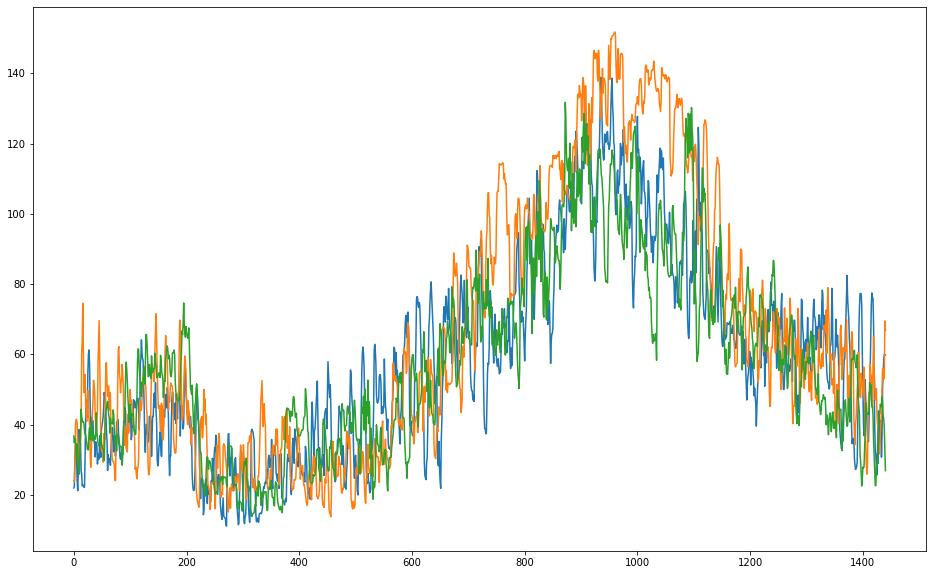

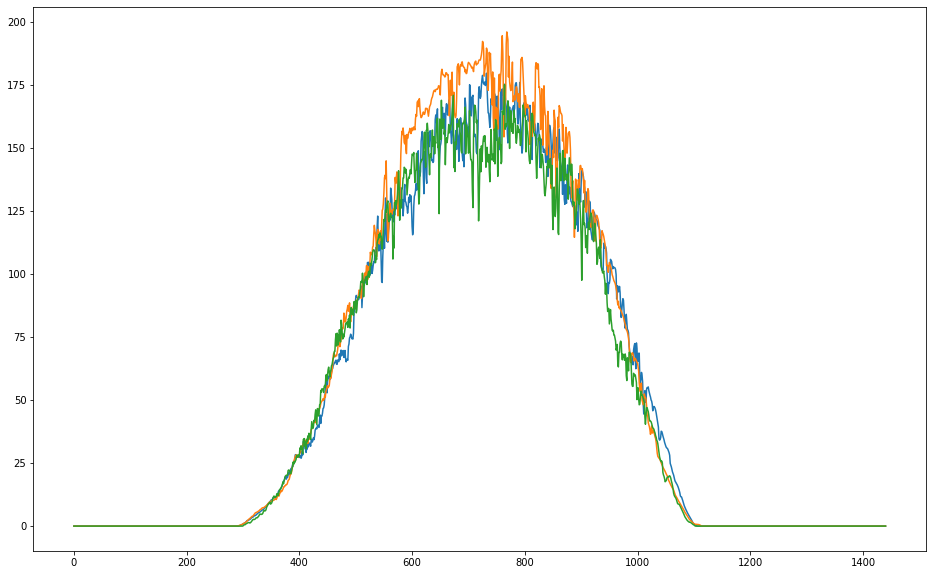

In [7]:
# Plot load data

fig = plt.figure(figsize=[16,10])
for k1 in range(0, Load.shape[1]):
    plt.plot(Load[:,k1])
    
fig = plt.figure(figsize=[16,10])
for k1 in range(0, Load.shape[1]):
    plt.plot(Generation[:,k1])

In [8]:
# Interpolate load and generation data from minute to second

############################################################
############################################################
#### Interpolate to change data from minutes to seconds ####
############################################################
############################################################

StartTime = 0
EndTime = StartTime + 86400
EndTime += 1

from scipy.interpolate import interp1d

print('Starting Interpolation...')

#interpolation for the whole period...
Time = list(range(StartTime,EndTime))
TotalTimeSteps = len(Time)
LoadSeconds = np.empty([3600*24 + 1, TotalLoads])
GenerationSeconds = np.empty([3600*24 + 1, TotalLoads])
# Interpolate to get minutes to seconds
for node in range(TotalLoads): # i is node
    
    t_seconds = np.linspace(0,len(Load_minutes[:,node]),int(3600*24 + 1))
        
    f = interp1d(np.arange(len(Load_minutes[:,node])), Load_minutes[:,node], kind='cubic', fill_value="extrapolate")
    LoadSeconds[:,node] = f(t_seconds) #spline method in matlab equal to Cubic Spline -> cubic
    
#     print(np.arange(len(Load_minutes[:,node])))
#     print(t_seconds)
    
    f = interp1d(np.arange(len(Generation_minutes[:,node])), Generation_minutes[:,node], kind='cubic', fill_value="extrapolate")
    GenerationSeconds[:,node]= f(t_seconds)
    
# Initialization
# then we take out only the window we want...
# LoadSeconds = LoadSeconds[StartTime:EndTime,:]
# GenerationSeconds = GenerationSeconds[StartTime:EndTime,:]
Load = LoadSeconds
Generation = GenerationSeconds
timeList = list(range(TotalTimeSteps))
print('Finished Interpolation!')

print(len(t_seconds))
print(len(Load_minutes[:,node]))

Load.shape

Starting Interpolation...
Finished Interpolation!
86401
1441


(86401, 3)

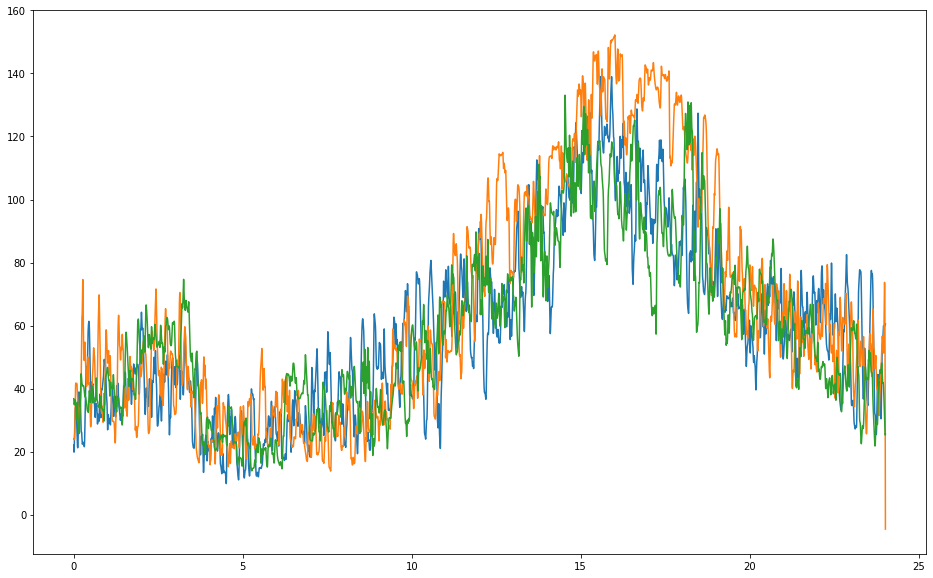

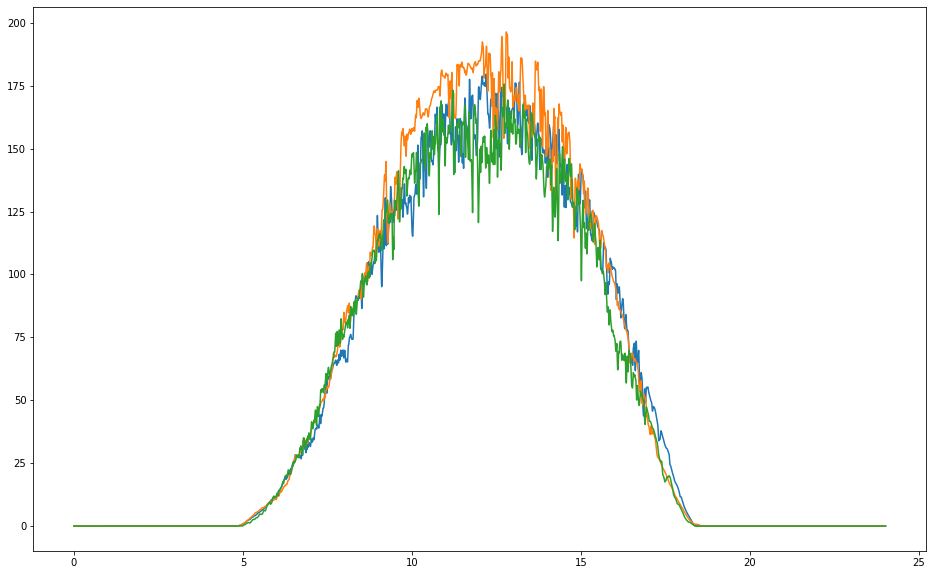

In [9]:
# Plot load and generation profiles

fig = plt.figure(figsize=[16,10])
for k1 in range(0, Load.shape[1]):
    plt.plot(t_seconds/60,Load[:,k1])
    
fig = plt.figure(figsize=[16,10])
for k1 in range(0, Load.shape[1]):
    plt.plot(t_seconds/60,Generation[:,k1])

In [10]:
# Inverter object class


class inverter():
    
    def __init__(self):
        
        #
        self.max_reactive_capacity = 1
        self.reactive_capacity = 1
    
        # Current reactive power
        self.reactive_power = 0
    
        # Volt-VAr curve breakpoints
        self.VBP = np.array([0.97, 0.99, 1.01, 1.03])
        
        # Lowpass filter cutoff frequency
        self.wlp = 2*np.pi*0.10
        
        # Lowpass filter timestep
        self.Ts = 1
        
        # Measured voltage
        self.Vmeas = np.zeros(86401)
        
        # Lowpass filter voltage
        self.Vlp = np.zeros(86401)
        
        # Array of reactive power
        self.reactive_power = np.zeros(86401)
        
        # attack status
        self.hackFlag = False
        
    def set_timesteps(self, startTimeStep, endTimeStep):
        self.startTimeStep = startTimeStep
        self.endTimeStep = endTimeStep
        
    # set the index of the node where the inverter is located
    def set_nodenum(self, nodenum):
        self.nodenum = nodenum
        
    # set the name of the node where the inverter is located
    def set_nodename(self, nodename):
        self.nodename = nodename    
    
    # set Volt-VAr curve breakpoints
    def set_VBP(self, VBP):
        self.VBP = VBP
    
    # set measured voltage
    def measure_voltage(self, timeStep, Vmeas):
        self.Vmeas[kt] = Vmeas
    
    # lowpass filter voltage measurements
    def lowpass(self, kt):
        self.Vlp[kt] = (1 - self.wlp*self.Ts)*self.Vlp[kt-1] + self.wlp*self.Ts*self.Vmeas[kt-1]
    
    # compute reactive power from lowpass filtered voltage and Volt-Var curve
    def compute_reactive_power_output(self, kt, Vcomp):
        if Vcomp <= self.VBP[0]:
            self.reactive_power[kt] = -100
        elif self.VBP[0] <= Vcomp <= self.VBP[1]:
            self.reactive_power[kt] =100/(self.VBP[1] - self.VBP[0])*(Vcomp - self.VBP[1])
        elif self.VBP[1] <= Vcomp <= self.VBP[2]:
            self.reactive_power[kt] = 0
        elif self.VBP[2] <= Vcomp <= self.VBP[3]:
            self.reactive_power[kt] = 100/(self.VBP[3] - self.VBP[2])*(Vcomp - self.VBP[2])
        elif self.VBP[3] <= Vcomp:
            self.reactive_power[kt] = 100
        # print(self.reactive_power)
        
    

x1 = inverter()
x1.set_VBP(np.array([0.97, 0.99, 1.01, 1.03]))
print(x1.VBP)

x1.compute_reactive_power_output(0,1.02)
print(x1.reactive_power)

print(x1.Vmeas)
print(x1.Vlp)

[0.97 0.99 1.01 1.03]
[50.  0.  0. ...  0.  0.  0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


In [11]:
# Run simulation

dss.run_command('Redirect feeder/03node_singlephase_balanced.dss')
dss.Solution.Solve()


if dss.Solution.Converged:
    print('Initial Model Converged. Proceeding to Next Step.')
    
else:
    print('Initial Solution Not Converged. Check Model for Convergence')
    #Doing this solve command is required for GridPV, that is why the monitors
    #go under a reset process
    dss.Monitors.ResetAll()
    
    #set solution Params
    #setSolutionParams(dss,'daily',1,1,'off',1000000,30000)
    dss.Solution.Mode(1)
    dss.Solution.Number(1)
    dss.Solution.StepSize(1)
    dss.Solution.ControlMode(-1)
    dss.Solution.MaxControlIterations(1000000)
    dss.Solution.MaxIterations(30000)
    #Easy process to get all names and count of loads, a trick to avoid
    #some more lines of code
    TotalLoads=dss.Loads.Count()
    AllLoadNames=dss.Loads.AllNames()
    print('OpenDSS Model Compliation Done.')

    

# Set slack bus (sourcebus) voltage reference in p.u. 
dss.Vsources.PU(SlackBusVoltage)

############################################
############ INIT NODES ####################
############################################
""" 
 nodes' variable is a dictionary contains all the nodes in the grid,
 with KEY is the node's number, VALUE is a dataframe with 
 ROW is ['Voltage', 'Generation', 'P', 'Q'] - Voltage is Voltage for each timestep; 
                                              P,Q is P,Q injection at that node for that timestep.
 and 
 COLUMN is each timestep for the whole simulation. 
 nodes = {
    1: dataFrame1,
    2: dataFrame2
 }
"""

nodes = {}
features = ['Voltage', 'Generation', 'P', 'Q']

# for k1 in range(len(AllLoadNames)):
#     print(k1)
#     df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
#     nodes[k1] = df
#     nodes[k1].loc['Generation'] = Generation[:,k1]
#     nodes[k1].loc['Load'] = Load[:,k1]
#     nodes[k1].loc['P'] = 0
#     nodes[k1].loc['Q'] = 0
#     nodes[k1].loc['Pinj'] = 0
#     nodes[k1].loc['Qinj'] = 0
    

    
################################################
############ INIT INVERTERS ####################
################################################
""" 
 inverters' variable is a dictionary contains all the inverters in the grid,
 with KEY is the node's number where we have inverters, VALUE is a list of inverters at that node.
 
 Each inverter has a dictionary:
     'device': Inverter_Object
     'controller: Controller_Object
     'info': contain scenario information in a dataframe (solar generation, sbar) for each timestep at that node
 }
"""

# we create inverters from node 5 to node (5+13)
offset = 5
numberofInverters = 13

# Simulation start and end steps, in seconds
simStartTimeStep = 12*3600+1
simEndTimeStep = 12*3600+1 + 3600

simStartTimeStep = 6*3600+1
simEndTimeStep = 18*3600+1

simStartTimeStep = 12*3600+1
simEndTimeStep = 12*3600+1 + 1200

simStartTimeStep = 12*3600+1 - 300
simEndTimeStep = 12*3600+1 + 600

# time array
time = np.arange(simStartTimeStep,simEndTimeStep)

totalSimTimeSteps = simEndTimeStep - simStartTimeStep + 1

# All buses and bus voltages
AllBuses = dss.Circuit.AllBusNames()
AllBusVoltage = np.zeros((TotalTimeSteps,len(AllBuses)))

# All loads and load voltages
LoadBuses = dss.Loads.AllNames()
LoadBusVoltage = np.zeros((TotalTimeSteps,len(LoadBuses)))



##################################################
# Set up loads
##################################################

Nload = 25
Load_factored = Load/1.25

load_indexes = np.zeros((len(LoadBuses), Nload)).astype(int)
for k1 in range(len(LoadBuses)):
    
    load_indexes[k1,:] = np.random.randint(0, Load.shape[1], size=Nload).astype(int)
#     load_indexes[k1,:] = load_indexes[k1,:].astype(int)
#     print(load_indexes[k1,:])

# print(load_indexes)
# print(Load_factored[load_indexes[0,:],0])


##################################################
# Set up generation
##################################################

Ngen = 15
Generation_factored = Generation/1.5

generation_indexes = np.zeros((len(LoadBuses), Ngen)).astype(int)
for k1 in range(len(LoadBuses)):
    
    generation_indexes[k1,:] = np.random.randint(0, Load.shape[1], size=Ngen).astype(int)
#     generation_indexes[k1,:] = generation_indexes[k1,:].astype(int)
#     print(generation_indexes[k1,:])

# print(generation_indexes)
# print(Generation_factored[generation_indexes[0,:],0])


##################################################
# Set up inverters
##################################################

# Create inverters and assign to existing load buses
inverters = []
for k1 in range(len(LoadBuses)):
    if LoadBuses[k1] == 's701a' or LoadBuses[k1] == 's702a':
#         for k2 in range(generation_indexes.shape[1]):
        for k2 in range(0,1):

    #         inverters[k1] = []
            tempinverter = inverter()
            tempinverter.set_timesteps(simStartTimeStep, simEndTimeStep)
            tempinverter.set_nodenum(k1)
            tempinverter.set_nodename(LoadBuses[k1])
            tempinverter.set_VBP(np.array([0.95, 0.97, 1.03, 1.05]))
            tempinverter.set_VBP(np.array([0.95, 0.99, 1.01, 1.05]))

            inverters.append(tempinverter)

    
##################################################
# ?
##################################################

# All buses and bus voltages
AllBuses = dss.Circuit.AllBusNames()
AllBusVoltage = np.zeros((TotalTimeSteps,len(AllBuses)))

# All loads and load voltages
LoadBuses = dss.Loads.AllNames()
LoadBusVoltage = np.zeros((TotalTimeSteps,len(LoadBuses)))

#
LoadBusPinj = np.zeros((TotalTimeSteps,len(LoadBuses))) 
LoadBusQinj = np.zeros((TotalTimeSteps,len(LoadBuses)))

kWloadTS = np.zeros((TotalTimeSteps,len(LoadBuses)))
kVArloadTS = np.zeros((TotalTimeSteps,len(LoadBuses)))

kWtotalTS = np.zeros((TotalTimeSteps,len(LoadBuses)))
kVArtotalTS = np.zeros((TotalTimeSteps,len(LoadBuses)))

# Real power load, injection, total for load buses
PloadTS = np.zeros((TotalTimeSteps,len(LoadBuses)))
PinjTS = np.zeros((TotalTimeSteps,len(LoadBuses)))
PtotalTS = np.zeros((TotalTimeSteps,len(LoadBuses)))

# Reactive power load, injection, total for load buses
QloadTS = np.zeros((TotalTimeSteps,len(LoadBuses)))
QinjTS = np.zeros((TotalTimeSteps,len(LoadBuses)))
QtotalTS = np.zeros((TotalTimeSteps,len(LoadBuses)))

# Nominal real and reactive power loads in kW and kVAr, from OpenDSS file
PloadNominal = np.zeros(len(LoadBuses))
QloadNominal = np.zeros(len(LoadBuses))
# Array of frequencies for load modulation
lf = np.zeros(len(LoadBuses))
for k1 in range(len(LoadBuses)):
    dss.Loads.Name(LoadBuses[k1])
    PloadNominal[k1] = dss.Loads.kW()
    QloadNominal[k1] = dss.Loads.kvar()
    lf[k1] = 1 + 0.2*(np.random.rand()-0.5)
    
print(LoadBuses)
print(PloadNominal)
print(QloadNominal)
print(lf)
print('')

# iterate through timesteps
for kt in range(simStartTimeStep,simEndTimeStep+1):
       
    # print when each minute has elapsed
    if (kt - 1) % 60 == 0:
        hh = int((kt-1)/3600)
        mm = int(((kt-1) - 3600*int((kt-1)/3600))/60)
        if mm <= 9:
            print(str(hh) + '.0' + str(mm))
        else:
            print(str(hh) + '.' + str(mm))
    
    # At first time step, initialize loads, with no control
    if kt == simStartTimeStep:
        for k1 in range(len(LoadBuses)):
            nodeName = LoadBuses[k1]
            dss.Loads.Name(nodeName)
            
#             dss.Loads.kW(1*Load_factored[kt, node])
#             dss.Loads.kvar(1*pf_converted*Load_factored[kt, node])
            
#             kWload = np.sum(Load_factored[kt,load_indexes[k1,:]])/25
#             kWloadTS[kt,k1] = kWload
#             kWtotalTS[kt,k1] = kWload
#             dss.Loads.kW(kWload)
            
            Pload = PloadNominal[k1]
            PloadTS[kt,k1] = Pload
            
            Ptotal = Pload
            PtotalTS[kt,k1] = Pload
            dss.Loads.kW(Ptotal)
            
#             print(LoadBuses[k1], dss.Loads.kW())
            
#             kVArload = pf_converted*kWload
#             kVArloadTS[kt,k1] = kVArload
#             kVArtotalTS[kt,k1] = kVArload
#             dss.Loads.kvar(kVArload)
            
            Qload = QloadNominal[k1]
            QloadTS[kt,k1] = Qload
            
            Qtotal = Qload
            QtotalTS[kt,k1] = Qload
            dss.Loads.kvar(Qtotal)
            
#             print(LoadBuses[k1], dss.Loads.kvar())
            
            print("%s : %4.3d kW , %4.3d kVAr" % (LoadBuses[k1], dss.Loads.kW(),dss.Loads.kvar()))

    # Compute total loading
    else:
        for k1 in range(len(LoadBuses)):
            nodeName = LoadBuses[k1]
            dss.Loads.Name(nodeName)
            
#             dss.Loads.kW(1*Load_factored[kt, node])
#             dss.Loads.kvar(1*pf_converted*Load_factored[kt, node])
            
#             kWload = np.sum(Load_factored[kt,load_indexes[k1,:]])/25
#             kWloadTS[kt,k1] = kWload
#             kWtotalTS[kt,k1] = kWload
#             dss.Loads.kW(kWload)

            # Calculate real power load, store value
            Pload =  PloadNominal[k1] + 25*np.sin(2*np.pi*1/60*kt)
            PloadTS[kt,k1] = Pload
        
            # Calculate real power injection, store value
            Pinj = 0*-np.sum(Generation_factored[kt,generation_indexes[k1,:]])/Ngen
            PinjTS[kt,k1] = Pinj
            
            # Calculate total real power, store value
            Ptotal = Pload + Pinj
            PtotalTS[kt,k1] = Ptotal
            
            # Assign total real power to load
            dss.Loads.kW(Ptotal)
            
#             kVArload = pf_converted*kWload
#             kVArloadTS[kt,k1] = kVArload
            
#             kVArtotal = kVArload
#             for k2 in range(len(inverters)):
#                 if inverters[k2].nodename == LoadBuses[k2]:
#                     kVArtotal = kVArtotal + inverters[k2].reactive_power[kt-1]/100*1
#             kVArtotalTS[kt,k1] = kVArtotal
#             dss.Loads.kvar(kVArtotal)
            
            # Calculate reactive power load, store value
            Qload = QloadNominal[k1] + 15*np.sin(2*np.pi*1/60*kt)
            QloadTS[kt,k1] = Qload
            
            # Calculate reactive power injection, store value
            Qinj = 0
            for k2 in range(len(inverters)):
                if inverters[k2].nodename == LoadBuses[k1]:
#                     print(inverters[k2].nodename, LoadBuses[k2])
                    Qinj = Qinj + inverters[k2].reactive_power[kt-1]/100*400
            Qinj = Qinj
            QinjTS[kt,k1] = Qinj
            
            # Calculate total reactive power, store value
            Qtotal = Qload + 1*Qinj
            QtotalTS[kt,k1] = Qtotal
            
            # Assign total reactive power to load
            dss.Loads.kvar(Qtotal)

    # solve power flow with OpenDSS file and newly assigned loads
    dss.Solution.Solve()
    if not dss.Solution.Converged:
        print('Solution Not Converged at Step:', kt)
        
    dss.Monitors.SampleAll()
    #get the voltage info
    #(voltage[0]+voltage[2]+voltage[4])/(DSSCircuit.ActiveElement.NumPhases*(Loads.kV*1000/(3**0.5)))
    nodeInfo = []
    
    for k1 in range(len(LoadBuses)):
        dss.Loads.Name(LoadBuses[k1])
        voltage = dss.CktElement.VoltagesMagAng()
#         print(dss.CktElement.NodeOrder())
#         print(voltage)
#         voltagePU = (voltage[0]+voltage[2]+voltage[4])/(dss.CktElement.NumPhases()*(dss.Loads.kV()*1000/(3**0.5)))

#         LoadBusVoltage[kt,k1] = voltagePU
        
#     for k1 in range(len(AllBuses)):
# #         dss.Loads.Name(LoadBuses[k1])
#         dss.Circuit.SetActiveBus(AllBuses[k1])
#         tempVoltagePU = dss.Bus.puVmagAngle()
# #         print(tempVoltagePU)
# #         print(tempVoltage)
# #         print(tempVoltage[::2])
#         tempVoltagePU = tempVoltagePU[::2]
#         tempVoltagePU = np.sum(tempVoltagePU)/len(tempVoltagePU)
# #         print(tempVoltage)
#         LoadBusVoltage[kt,k1] = tempVoltagePU
    
    # Iterate through all buses, store voltage
    for k1 in range(len(AllBuses)):
        dss.Circuit.SetActiveBus(AllBuses[k1])
        tempVoltagePU = dss.Bus.puVmagAngle()[::2]
#         print(AllBuses[k1])
#         print(tempVoltage)
        tempVoltagePU = np.sum(tempVoltagePU)/len(tempVoltagePU)
#         tempVoltagePU = tempVoltage/(dss.Bus.kVBase()*1000)        
        AllBusVoltage[kt,k1] = tempVoltagePU
        
#         print(dss.Bus.VMagAngle())
        
#         if kt == simStartTimeStep + 20:
#             print(AllBuses[k1], tempVoltagePU)
        
#     for k1 in range(len(LoadBuses)):
        
#         inverters[k1].measure_voltage(kt,LoadBusVoltage[kt,k1])
#         inverters[k1].lowpass(kt)
    
    # Iterate through inverters
    for k1 in range(len(inverters)):
        
        # Get index of bus at which inverter is located - fix this
        AllBuses.index(inverters[k1].nodename[1:4])
        
        # inverter takes local voltage measurement
        inverters[k1].measure_voltage(kt,AllBusVoltage[kt,AllBuses.index(inverters[k1].nodename[1:4])])
        # inverter lowpass filters voltage
        inverters[k1].lowpass(kt)
        
        # set reactive power setpoint to 0 for first 10 time steps (to allow lowpass filter to ramp up)
        if kt >= simStartTimeStep + 10:            
            inverters[k1].compute_reactive_power_output(kt, inverters[k1].Vlp[kt])
        
#         inverters[k1].compute_reactive_power_output(kt, inverters[k1].Vlp[kt])
    
    # Attack inverters at this timestep
    if kt == 12*3600+1+60:
        for k1 in range(len(inverters)):
            # Set new Volt-VAr curve breakpoints
            inverters[k1].set_VBP(inverters[k1].VBP)
            if np.random.rand() <= 2:
                inverters[k1].hackFlag = True
                inverters[k1].set_VBP(np.array([0.99, 0.995, 1.005, 1.01]))


                

Initial Model Converged. Proceeding to Next Step.
['s701a', 's702a', 's703a']
[200. 400. 100.]
[ 50. 100.  50.]
[0.98377072 0.91736364 0.988844  ]

11.55
s701a :  200 kW ,  050 kVAr
s702a :  400 kW ,  100 kVAr
s703a :  100 kW ,  050 kVAr
11.56
11.57
11.58
11.59
12.00
12.01
12.02
12.03
12.04
12.05
12.06
12.07
12.08
12.09
12.10


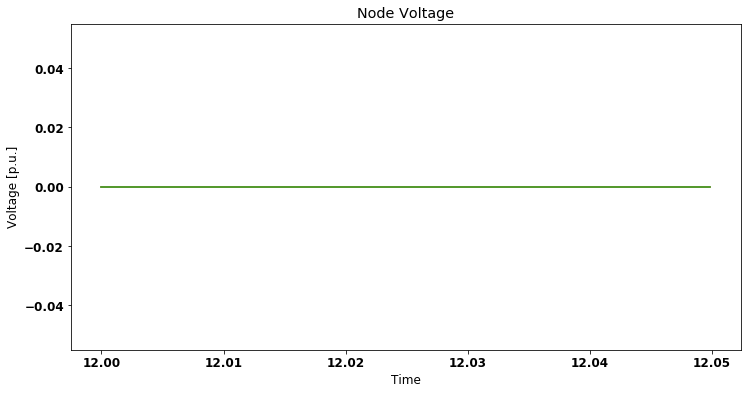

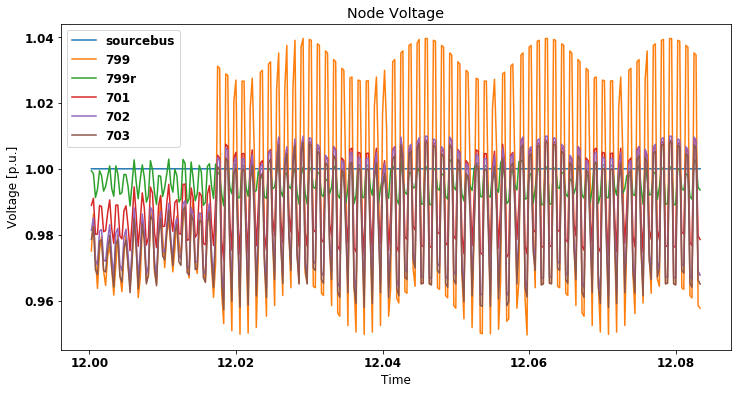

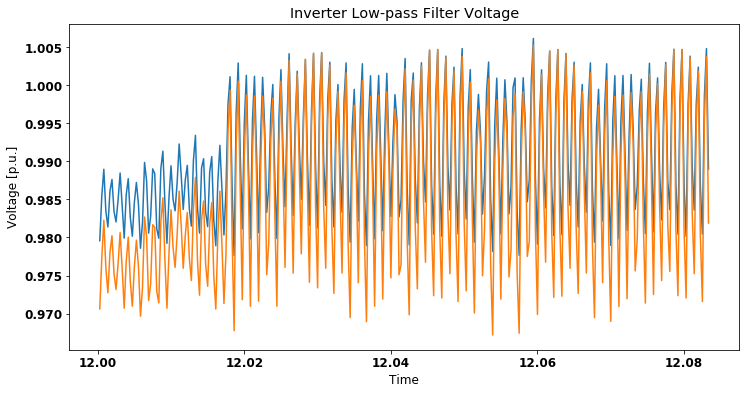

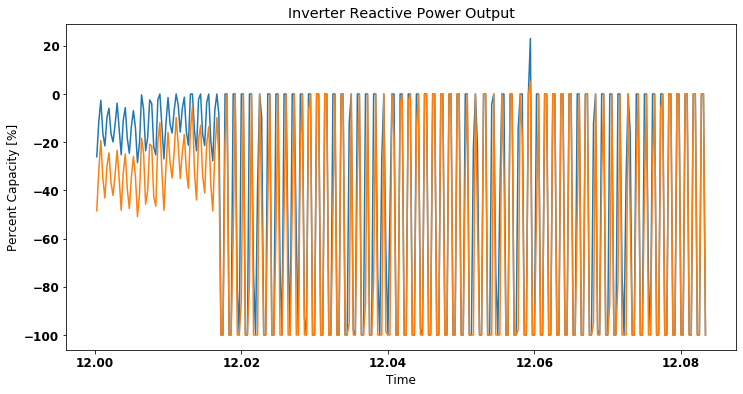

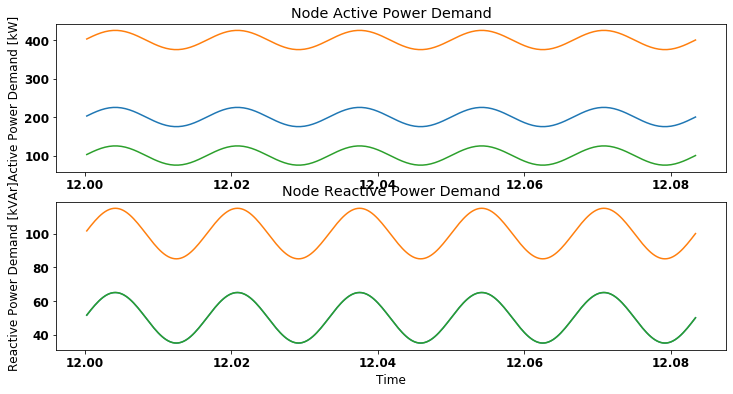

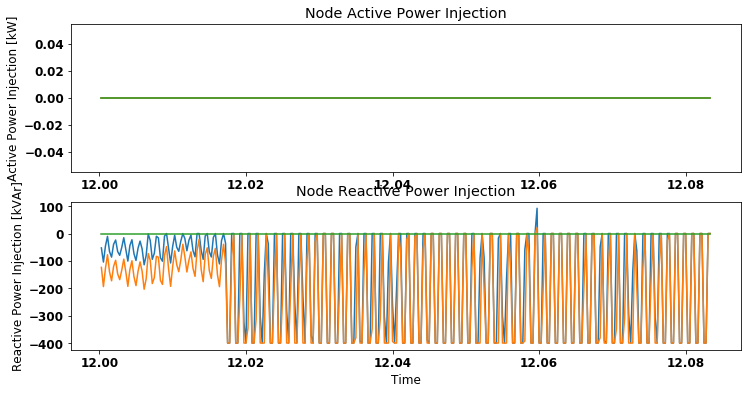

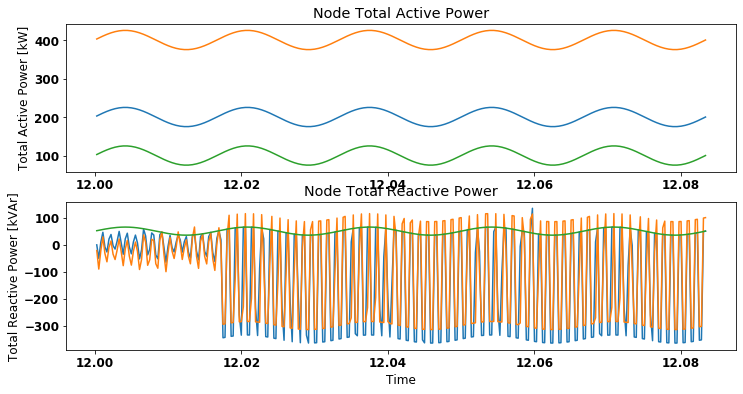

In [12]:
font = {'weight':'bold', 'size':12}

plt.rc('font', **font)

plotStartTimeStep = 12*3600 + 1
plotEndTimeStep = 12*3600 + 1 + 300

time = np.arange(plotStartTimeStep,plotEndTimeStep)

timehh = ((time-1)/3600).astype(int)
timemm = ((time-1) - 3600*timehh)/60

timeplot = timehh.astype(float) + timemm/100

fig = plt.figure(figsize=[12,6])
# for k1 in range(0,LoadBusVoltage.shape[1]):
for k1 in range(len(LoadBuses)):
#     plt.plot(time/3600,LoadBusVoltage[plotStartTimeStep:plotEndTimeStep,k1])
    plt.plot(timeplot,LoadBusVoltage[plotStartTimeStep:plotEndTimeStep,k1] - np.mean(LoadBusVoltage[plotStartTimeStep:plotEndTimeStep,k1]))
#     print(LoadBuses[k1])
plt.title('Node Voltage')
plt.xlabel('Time')
plt.ylabel('Voltage [p.u.]')
plt.show()


fig = plt.figure(figsize=[12,6])
# for k1 in range(0,LoadBusVoltage.shape[1]):
for k1 in range(len(AllBuses)):
    plt.plot(time/3600,AllBusVoltage[plotStartTimeStep:plotEndTimeStep,k1],label=AllBuses[k1])
#     print(LoadBuses[k1])
plt.title('Node Voltage')
plt.xlabel('Time')
plt.ylabel('Voltage [p.u.]')
plt.legend()
plt.show()

fig = plt.figure(figsize=[12,6])
for k1 in range(0,len(inverters)):
#     plt.plot(inverters[k1].Vmeas[plotStartTimeStep:plotEndTimeStep])
    plt.plot(time/3600,inverters[k1].Vlp[plotStartTimeStep:plotEndTimeStep])
# plt.ylim([0.85, 1.05])
plt.title('Inverter Low-pass Filter Voltage')
plt.xlabel('Time')
plt.ylabel('Voltage [p.u.]')
plt.show()

fig = plt.figure(figsize=[12,6])
for k1 in range(0,len(inverters)):
    plt.plot(time/3600,inverters[k1].reactive_power[plotStartTimeStep:plotEndTimeStep])
# plt.ylim([-100, 100])
plt.title('Inverter Reactive Power Output')
plt.xlabel('Time')
plt.ylabel('Percent Capacity [%]')
plt.show()

# fig = plt.figure(figsize=[12,6])
# plt.plot(time/3600,PloadTS[plotStartTimeStep:plotEndTimeStep,:])
# plt.plot(time/3600,QloadTS[plotStartTimeStep:plotEndTimeStep,:])
# plt.title('Load Demands')
# plt.xlabel('Time')
# plt.ylabel('Percent Capacity [%]')
# plt.show()

fig = plt.figure(figsize=[12,6])
plt.subplot(2,1,1)
plt.plot(time/3600,PloadTS[plotStartTimeStep:plotEndTimeStep,:])
plt.title('Node Active Power Demand')
# plt.xlabel('Time')
plt.ylabel('Active Power Demand [kW]')
plt.subplot(2,1,2)
plt.plot(time/3600,QloadTS[plotStartTimeStep:plotEndTimeStep,:])
plt.title('Node Reactive Power Demand')
plt.xlabel('Time')
plt.ylabel('Reactive Power Demand [kVAr]')
plt.show()

# fig = plt.figure(figsize=[12,6])
# plt.plot(time/3600,PinjTS[plotStartTimeStep:plotEndTimeStep,:])
# plt.plot(time/3600,QinjTS[plotStartTimeStep:plotEndTimeStep,:])
# plt.title('Injection')
# plt.show()

fig = plt.figure(figsize=[12,6])
plt.subplot(2,1,1)
plt.plot(time/3600,PinjTS[plotStartTimeStep:plotEndTimeStep,:])
plt.title('Node Active Power Injection')
# plt.xlabel('Time')
plt.ylabel('Active Power Injection [kW]')
plt.subplot(2,1,2)
plt.plot(time/3600,QinjTS[plotStartTimeStep:plotEndTimeStep,:])
plt.title('Node Reactive Power Injection')
plt.xlabel('Time')
plt.ylabel('Reactive Power Injection [kVAr]')
plt.show()

# fig = plt.figure(figsize=[12,6])
# plt.plot(time/3600,PtotalTS[plotStartTimeStep:plotEndTimeStep,:])
# plt.plot(time/3600,QtotalTS[plotStartTimeStep:plotEndTimeStep,:])
# plt.title('Total')
# plt.show()

fig = plt.figure(figsize=[12,6])
plt.subplot(2,1,1)
plt.plot(time/3600,PtotalTS[plotStartTimeStep:plotEndTimeStep,:])
plt.title('Node Total Active Power')
# plt.xlabel('Time')
plt.ylabel('Total Active Power [kW]')
plt.subplot(2,1,2)
plt.plot(time/3600,QtotalTS[plotStartTimeStep:plotEndTimeStep,:])
plt.title('Node Total Reactive Power')
plt.xlabel('Time')
plt.ylabel('Total Reactive Power [kVAr]')
plt.show()

# print(timeplot)


In [13]:
dss.Circuit.SetActiveBus(AllBuses[2])
dss.Bus.Nodes()

[1]

In [14]:
inverters[0].nodename

's701a'

In [15]:
print(AllBuses)

AllBusVoltage[simStartTimeStep,:]

['sourcebus', '799', '799r', '701', '702', '703']


array([0.99999776, 0.95769242, 0.99356542, 0.97853655, 0.96769383,
       0.96499318])

In [16]:
Zbase = ((4.8e3/np.sqrt(3))**2)/(2500e3/3)

print(Zbase)

dss.Lines.Name('line_799_701')
dss.Lines.Name()
dss.Lines.XMatrix()

Xmat = np.array(dss.Lines.XMatrix())
Xmat = Xmat*dss.Lines.Length()
Xmatpu = Xmat/Zbase

print(Xmatpu)


dss.Lines.Name('line_701_702')
dss.Lines.Name()
dss.Lines.XMatrix()

Xmat = np.array(dss.Lines.XMatrix())
Xmat = Xmat*dss.Lines.Length()

Xmatpu = Xmat/Zbase

print(Xmatpu)

x01 = 0.08
x12 = 0.00759549
x23 = 0.00596788

print(Xmat)

Xmat = np.array([[x01, x01, x01],[x01, x01+x12, x01+x12],[x01, x01+x12,x01+x12+x23]])
spla.inv(Xmat)

Xmat.shape

9.216000000000001
[0.02170139]
[0.02170139]
[0.2]


(3, 3)

In [17]:
Ns = 20

# for kt in range(12*3600+1+60,simEndTimeStep-Ns):
for kt in range(12*3600+1+60,12*3600+1+60+2):
    
    print(kt)
    
    xx = AllBusVoltage[kt:kt+Ns,1:].T
    print(xx.shape)
    
    yy = AllBusVoltage[kt+1:kt+1+Ns,1:].T
    print(yy.shape)

    xxblkdiag = spla.block_diag(xx.T,xx.T)
    for k1 in range(1,xx.shape[0]-1):
        xxblkdiag = spla.block_diag(xxblkdiag,xx.T)
    print(xxblkdiag.shape)

    yyvec = yy.T.reshape((-1,1), order='F')
    print(yyvec.shape)

    Bvec = spla.inv(xxblkdiag.T@xxblkdiag)@(xxblkdiag.T@yyvec)
#     print(Bvec)
    
    Ahat = Bvec.reshape((xx.shape[0],xx.shape[0]), order='F').T
    print(Ahat)
    
    A = spla.inv(Xmat)@Ahat
    print(A)
    
    U, s, Vh = spla.svd(A)
    print(U)
    print(s)
    print(Vh)
    
#     print(np.diag(s[[0]]))
        
    print(U[:,[0]]@np.diag(s[[0]])@Vh[[0],:])
    

43261
(5, 20)
(5, 20)
(100, 25)
(100, 1)
[[ -2.81719011 -10.78634932  26.55396      9.92205135 -21.93547856]
 [  0.83590044   2.44575382  -0.43348508  -3.16673096   1.3032706 ]
 [ -0.2212594   -1.45421917   7.66045022  -0.41419004  -4.60254595]
 [ -0.79931956  -3.79338138  12.55393767   2.0851616   -9.09386104]
 [ -0.80304153  -3.810622    12.60160145   1.24688141  -8.28295397]]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5 is different from 3)

In [20]:
# Estimate slopes of Volt-VAr curves for all nodes

# Number of observations
Ns = 20

# for kt in range(12*3600+1+60,simEndTimeStep-Ns):
for kt in range(12*3600+1+60,12*3600+1+60+2):
    
    print(kt)
    
    # Voltage measurements
    xx = AllBusVoltage[kt:kt+Ns,3:].T - 1
    print(xx.shape)
    
    yy = AllBusVoltage[kt+1:kt+1+Ns,1:].T
#     print(yy.shape)
    
    # Reactive power measurements
    yy = QtotalTS[kt+1:kt+1+Ns,:].T
    print(yy.shape)

    # block diagonalize xx
    xxblkdiag = xx.T
    for k1 in range(1,yy.shape[0]):
        xxblkdiag = spla.block_diag(xxblkdiag,xx.T)
#     print(xxblkdiag.shape)

    # vectorize yy
    yyvec = yy.T.reshape((-1,1), order='F')
#     print(yyvec.shape)

    # solve least squares
    Bvec = spla.inv(xxblkdiag.T@xxblkdiag)@(xxblkdiag.T@yyvec)
    print(Bvec)
    
    B = Bvec.reshape((xx.shape[0],yy.shape[0]), order='F')
    print(B)
    
    A = B.T
    print(A)
    
#     A = spla.inv(Xmat)@Ahat
#     print(A)
    
    U, s, Vh = spla.svd(A)
#     print(U)
    print(s)
#     print(Vh)
    
# #     print(np.diag(s[[0]]))
        
    print(U[:,0:2]@np.diag(s[0:2])@Vh[0:2,:])

# print('yy')
# print(yy)
# print('yyvec')
# print(yyvec)

43261
(3, 20)
(3, 20)
[[-6.83654061e+04]
 [ 5.04592209e+04]
 [ 1.72796193e+03]
 [-9.23932732e+04]
 [ 6.13407464e+04]
 [ 6.41498914e+03]
 [ 7.31967382e+01]
 [ 1.95156290e+04]
 [-1.95120868e+04]]
[[-6.83654061e+04 -9.23932732e+04  7.31967382e+01]
 [ 5.04592209e+04  6.13407464e+04  1.95156290e+04]
 [ 1.72796193e+03  6.41498914e+03 -1.95120868e+04]]
[[-6.83654061e+04  5.04592209e+04  1.72796193e+03]
 [-9.23932732e+04  6.13407464e+04  6.41498914e+03]
 [ 7.31967382e+01  1.95156290e+04 -1.95120868e+04]]
[140187.4789287   25910.10083425   1013.82720472]
[[-68736.9650218   49960.4074804    1221.12006881]
 [-92115.89806353  61713.11915506   6793.35529901]
 [   146.89458414  19614.56742792 -19411.55588482]]
43262
(3, 20)
(3, 20)
[[-68655.91532848]
 [ 51585.832404  ]
 [  1485.55503652]
 [-92743.93540689]
 [ 62342.30256242]
 [  6132.93263739]
 [   148.79006398]
 [ 19403.19716446]
 [-19454.32759025]]
[[-68655.91532848 -92743.93540689    148.79006398]
 [ 51585.832404    62342.30256242  19403.19716446

In [ ]:
# Estimate slopes of Volt-VAr curves for all nodes

# Number of observations
Ns = 20

# for kt in range(12*3600+1+60,simEndTimeStep-Ns):
for kt in range(12*3600+1+60,12*3600+1+60+6):
    
    print(kt)
    
    # Voltage measurements
    xx = AllBusVoltage[kt:kt+Ns,3:].T - 1
    print(xx.shape)
    
    yy = AllBusVoltage[kt+1:kt+1+Ns,1:].T
#     print(yy.shape)
    
    # Reactive power measurements
    yy = QtotalTS[kt+1:kt+1+Ns,:].T
    print(yy.shape)

    # block diagonalize xx
    xxblkdiag = xx.T
    for k1 in range(1,yy.shape[0]):
        xxblkdiag = spla.block_diag(xxblkdiag,xx.T)
#     print(xxblkdiag.shape)

    # vectorize yy
    yyvec = yy.T.reshape((-1,1), order='F')
#     print(yyvec.shape)

    # solve least squares
    Bvec = spla.inv(xxblkdiag.T@xxblkdiag)@(xxblkdiag.T@yyvec)
    print(Bvec)
    
    B = Bvec.reshape((xx.shape[0],yy.shape[0]), order='F')
    print(B)
    
    A = B.T
    print(A)
    
#     A = spla.inv(Xmat)@Ahat
#     print(A)
    
    U, s, Vh = spla.svd(A)
#     print(U)
    print(s)
#     print(Vh)
    
# #     print(np.diag(s[[0]]))
        
    print(U[:,0:2]@np.diag(s[0:2])@Vh[0:2,:])

print('yy')
print(yy)
print('yyvec')
print(yyvec)

In [ ]:
dir(dss.Lines.AllNames)

dss.Lines.AllNames()

In [ ]:
Zbase = ((4.8e3/np.sqrt(3))**2)/(2500e3/3)

print(Zbase)

dss.Lines.Name('line_799_701')
dss.Lines.Name()
dss.Lines.XMatrix()

Xmat = np.array(dss.Lines.XMatrix())
Xmat = Xmat*dss.Lines.Length()
Xmatpu = Xmat/Zbase

print(Xmatpu)


dss.Lines.Name('line_701_702')
dss.Lines.Name()
dss.Lines.XMatrix()

Xmat = np.array(dss.Lines.XMatrix())
Xmat = Xmat*dss.Lines.Length()

Xmatpu = Xmat/Zbase

print(Xmatpu)

x01 = 0.1
x12 = 0.00759549
x23 = 0.00596788

X = np.array([[x01, x01, x01],[x01, x01+x12, x01+x12],[x01, x01+x12,x01+x12+x23]])
spla.inv(X)

print(X)
print(spla.inv(X))

In [ ]:
QinjTS.shape

In [ ]:
QtotalTS.shape

In [ ]:
import numpy as np

A = np.array([[1, 2],[3, 4]])
B = np.array([[2, 0],[0, -1]])

print(A@B)

print(B@A)